# Colab Imports

In [91]:
from google.colab import drive
from google.colab import userdata
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installation

In [92]:
!pip -q install langgraph langchain_openai langchain_community tiktoken konlpy langchain-pinecone pinecone-notebooks

# Settings & Loadings

In [93]:
import os
import json
import pandas as pd

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

PROFECT_DIR = os.path.join("/content/drive/MyDrive", "Profect SAE")
CSVs = os.path.join(PROFECT_DIR, "test_data/CSVs")
files = os.listdir(CSVs)
csv_files = [
    file for file in files
      if file.endswith(".csv")
]

df_one = pd.read_csv(os.path.join(CSVs, csv_files[0]))
print(df_one.iloc[0])

title      [종합] 김태희, 해외서 권총 강도 당했다…'연매출 1100억' 정샘물 "피해액 2...
url        https://m.entertain.naver.com/article/312/0000...
content    본문 바로가기 naver 엔터 뉴스 스포츠 사용자 링크 로그인 검색 홈 드라마 영화...
Name: 0, dtype: object


# Things I need to do to add feedback loop

1. New(or refactored) state and state management logic
2. Applying Short-term memory for feedback: CheckPointer
  - [LangGraph Memory](https://langchain-ai.github.io/langgraph/concepts/memory/)
  - [LangGraph CheckPointer with InMemorySaver](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpoints)
3. Modifying Generation Flows based on 5W1H below.
  - Who?(Target): User
  - When?: After stocks are generated and returned.
  - Where?: (Feedback) Chrome Extension
  - What?: Whether user liked it or not.
  - How?: By adding a field at the state and use `InMemorySaver`
  - Why?: To improve the result.

4. Step By Step
  - new state
  - new Feedback Agent or modified RAG Agent

## Schema, DTO & State

### Schema
- `Stock`

In [94]:
from pydantic import BaseModel, Field
from typing import Optional, List

class Stock(BaseModel):
  korean_name: str
  english_name: str
  market: str
  ticker_code: str

### DTO
- `StockGenRequestDto`
- `FeedbackRequestDto`
- `StockGenResponseDto`

In [95]:
from pydantic import BaseModel, Field
from typing import Optional, List

class StockGenRequestDto(BaseModel):
  original_title: str = Field(..., min_length=1)
  original_url: str = Field(..., min_length=5, max_length=2083)
  original_content: str = Field(..., min_length=1)

class FeedbackRequestDto(BaseModel):
  state_id: str = Field(..., min_length=1)

class StockGenResponseDto(BaseModel):
  state_id: str = Field(..., min_length=1)
  generated_stocks: list[Stock]

### States
- `PreprocessingFlowState`
- `RAGFlowState`
- `FlowState`: Pending

In [96]:
from pydantic import BaseModel, Field
from typing import Optional, List

class PreprocessingFlowState(BaseModel):
  state_id: str = Field(..., min_length=1)
  request_dto: StockGenRequestDto
  route: str
  preprocessed_title: str
  preprocessed_url: str
  preprocessed_content: str

class RAGFlowState(BaseModel):
  state_id: str = Field(..., min_length=1)
  generated_stocks: list[Stock]

## Nodes

### Preprocessing

#### Tools
- `text_cleaning`

In [97]:
def text_cleaning(text: str) -> str:
  """Cleaning text by removing unnecessary characters and spaces."""
  if isinstance(text, str):
      # Convert to lowercase
      text = text.lower()
      # Remove leading and trailing spaces
      text = text.strip()
      # Replace multiple spaces with a single space
      text = re.sub(r'\s+', ' ', text)
      # Remove special characters except for common ones
      text = re.sub(r'[^\w\s.,!?$%&@()-]', '', text)
  return text

#### Router Node
- `prerocessing_router_node`

In [98]:
import re

def preprocessing_router_node(preprocessing_flow_state: PreprocessingFlowState):
  print("Routing")
  request_dto = preprocessing_flow_state.request_dto

  youtube_pattern = r"^https?://(www\.)?youtube\.com"
  naver_news_pattern = r"^https?://n\.news\.naver\.com"
  naver_entertainment_pattern = r"^https?://m\.entertain\.naver\.com"
  naver_sports_pattern = r"^https?://m\.sports\.naver\.com"

  if re.match(naver_news_pattern, request_dto.original_url):
      route = "naver_news"

  elif re.match(naver_entertainment_pattern, request_dto.original_url):
      route = "naver_entertainment"

  elif re.match(naver_sports_pattern, request_dto.original_url):
      route = "naver_sports"

  elif re.match(youtube_pattern, request_dto.original_url):
      route = "youtube"
  else:
      route = "default"

  # Basic text cleaning
  preprocessing_flow_state.preprocessed_title = text_cleaning(request_dto.original_title)
  preprocessing_flow_state.preprocessed_content = text_cleaning(request_dto.original_content)
  preprocessing_flow_state.preprocessed_url = request_dto.original_url
  preprocessing_flow_state.route = route
  return preprocessing_flow_state

#### Preprocessing Nodes Based on `flow_state.preprocessing_flow_state.route`
1. `naver_news_preprocessing_node`
2. `naver_entertainment_preprocessing_node`
3. `naver_sports_preprocessing_node`
4. `youtube_preprocessing_node`
5. `default_preprocessing_node`

---

1. `content_parser`

In [99]:
import re

def content_parser(text: str, remove_after: str = None, patterns: list = None) -> str:
  if not isinstance(text, str):
      return text

  if remove_after:
      text = re.sub(fr"{remove_after}.*", "", text, flags=re.IGNORECASE)

  if patterns:
    combined_pattern = "|".join(patterns)
    text = re.sub(combined_pattern, "", text, flags=re.IGNORECASE)

  # Remove excessive whitespace
  text = re.sub(r"\s+", " ", text).strip()

  return text

In [100]:
def preprocessing_naver_news_node(preprocessing_flow_state: PreprocessingFlowState):
  print("NEWS")
  requestDto = preprocessing_flow_state.request_dto
  """Cleans Naver News content."""
  preprocessing_flow_state.preprocessed_content = content_parser(requestDto.original_content, remove_after="copyright .*?\. all rights reserved")
  preprocessing_flow_state.preprocessed_content = content_parser(requestDto.original_content, remove_after="기사 공유하기")
  preprocessing_flow_state.preprocessed_content = content_parser(requestDto.original_content, patterns = [
          r"본문 바로가기", r"naver", r"뉴스", r"엔터", r"스포츠", r"날씨", r"프리미엄",
          r"사용자 링크", r"로그인", r"서비스", r"더보기", r"검색", r"언론사별", r"정치",
          r"경제", r"사회", r"생활문화", r"it과학", r"세계", r"랭킹", r"신문보기",
          r"오피니언", r"tv", r"팩트체크", r"알고리즘 안내", r"정정보도 모음"])
  return preprocessing_flow_state

def preprocessing_naver_entertainment_node(preprocessing_flow_state: PreprocessingFlowState):
  print("ENT")
  requestDto = preprocessing_flow_state.request_dto

  """Cleans Naver Entertainment content."""
  preprocessing_flow_state.preprocessed_content = content_parser(requestDto.original_content, remove_after="copyright .*?\. all rights reserved")
  preprocessing_flow_state.preprocessed_content = content_parser(requestDto.original_content, remove_after="기사 공유하기")
  preprocessing_flow_state.preprocessed_content = content_parser(requestDto.original_content, patterns = [
      r"본문 바로가기", r"naver", r"엔터", r"뉴스", r"스포츠", r"사용자 링크", r"로그인",
      r"검색", r"홈", r"드라마", r"영화", r"뮤직", r"연애", r"포토", r"랭킹", r"최신뉴스", r"연재", r"종합"])
  return preprocessing_flow_state

def preprocessing_naver_sports_node(preprocessing_flow_state: PreprocessingFlowState):
  print("SPORTS")
  requestDto = preprocessing_flow_state.request_dto
  """Cleans Naver Sports content."""
  preprocessing_flow_state.preprocessed_content = content_parser(requestDto.original_content, remove_after="copyright .*?\. all rights reserved")
  preprocessing_flow_state.preprocessed_content = content_parser(requestDto.original_content, remove_after="기사 공유하기")
  return preprocessing_flow_state

def preprocessing_youtube_node(preprocessing_flow_state: PreprocessingFlowState):
  print("YOUTUBE")
  requestDto = preprocessing_flow_state.request_dto
  """Cleans YouTube transcript content."""
  preprocessing_flow_state.preprocessed_content = content_parser(requestDto.original_content, remove_after="더보기")
  preprocessing_flow_state.preprocessed_content = content_parser(requestDto.original_content, patterns = [r"kr", r"탐색", r"건너뛰기", r"만들기"])
  return preprocessing_flow_state

## Flow

### Preprocessing Flow

In [101]:
from langgraph.graph import StateGraph, START, END

preprocessing_graph = StateGraph(state_schema=PreprocessingFlowState)

# Registering Noes

## router
preprocessing_graph.add_node("preprocessing_router_node", preprocessing_router_node)

## preprocessing
preprocessing_graph.add_node("naver_news_preprocessing_node", preprocessing_naver_news_node)
preprocessing_graph.add_node("naver_entertainment_preprocessing_node", preprocessing_naver_entertainment_node)
preprocessing_graph.add_node("naver_sports_preprocessing_node", preprocessing_naver_sports_node)
preprocessing_graph.add_node("youtube_preprocessing_node", preprocessing_youtube_node)


# Registering Edges
# Conditional Edges
preprocessing_graph.add_edge(START, "preprocessing_router_node")

preprocessing_graph.add_conditional_edges(
    "preprocessing_router_node",
    lambda flow_state: flow_state.route,
    {
        "naver_news": "naver_news_preprocessing_node",
        "naver_entertainment": "naver_entertainment_preprocessing_node",
        "naver_sports": "naver_sports_preprocessing_node",
        "youtube": "youtube_preprocessing_node",
        "default": END,
    }
)

preprocessing_graph.add_edge("naver_news_preprocessing_node", END)
preprocessing_graph.add_edge("naver_entertainment_preprocessing_node", END)
preprocessing_graph.add_edge("naver_sports_preprocessing_node", END)
preprocessing_graph.add_edge("youtube_preprocessing_node", END)

# agent Init
preprocessing_agent = preprocessing_graph.compile()

### Visualization: Preprocessing Flow

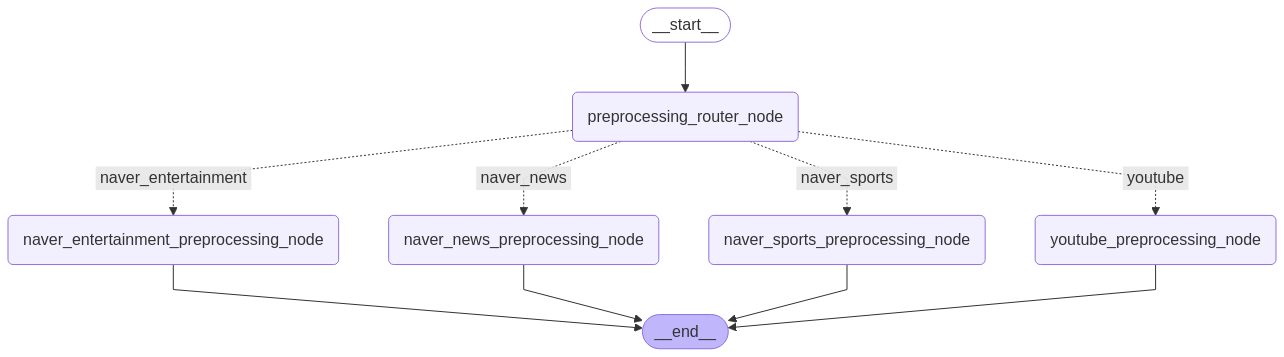

In [102]:
# Visualize your graph
from IPython.display import Image, display
png = preprocessing_agent.get_graph().draw_mermaid_png()
display(Image(png))

## Tesing Agents

### Testing Preprocessing Agents

In [109]:
import uuid

for row in df_one.itertuples(index=False):
  # Preprocessing
  stock_gen_request_dto = StockGenRequestDto(
      original_title=row.title,
      original_url=row.url,
      original_content=row.content
  )
  preprocessing_flow_state = PreprocessingFlowState(
      state_id="test",
      request_dto=stock_gen_request_dto,
      route="",
      preprocessed_title="",
      preprocessed_url="",
      preprocessed_content="")

  print("Title: ", preprocessing_flow_state.request_dto.original_title + "\n")
  print("Preprocessing Agent")
  preprocessing_agent = preprocessing_graph.compile()
  preprocessed_result = preprocessing_agent.invoke(preprocessing_flow_state)
  before_length = len(preprocessed_result['request_dto'].original_content)
  after_length = len(preprocessed_result['preprocessed_content'])
  print("Before: "+str(before_length))
  print("After: " +str(after_length))
  print("")

  print("RAG Agent")


  print("")
  print("---------------------------")
  break


Title:  [종합] 김태희, 해외서 권총 강도 당했다…'연매출 1100억' 정샘물 "피해액 2000만원"('백억짜리')

Preprocessing Agent
Routing
ENT
Before: 2678
After: 2526

RAG Agent

---------------------------
